In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
threshold_sp = 20     # Salt-and-pepper noise threshold

In [4]:
detected_noises = []  # Detected noise types


In [5]:
def detect_salt_pepper_noise(image):

    # Check for salt-and-pepper noise
    median_diff = np.mean(np.abs(image - cv2.medianBlur(image, 3)))
    if median_diff > threshold_sp:
        detected_noises.append('salt_pepper')

In [6]:
def detect_sine_wave(image):
   
    
    # Perform the 2D FFT of the image
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift the zero frequency component to the center
    
    # Calculate the magnitude spectrum for visualization (not necessary for detection)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)  # +1 to avoid log(0)

    # Define the center of the frequency spectrum
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    # Optionally filter out low frequencies (central part of spectrum)
    fshift[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0

    # Inverse FFT to reconstruct the image without low-frequency components
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Compute the difference between the original image and the processed image
    sine_wave_diff = np.mean(np.abs(image - img_back))

    # Adjust threshold based on empirical observations
    threshold = 10  # A higher threshold for sine wave detection

    # If the difference is greater than the threshold, consider it as sine wave noise
    if sine_wave_diff > threshold:
        detected_noises.append('sine_wave')


In [7]:
def detect_image_is_blurred(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:  # Check if the image is colored (3 channels)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    # Apply Laplacian to the image
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    
    # Calculate the variance of the Laplacian
    laplacian_var = np.var(laplacian)
    
    # Set a threshold value based on the image type
    blur_threshold = 1000  # You can adjust this threshold as needed
    
    # Check if the variance is below the threshold (indicating blur)
    if laplacian_var < blur_threshold:
        detected_noises.append('blurred')
        print("Blur detected")
    else:
        print("Image is not blurred")

In [19]:
#function to check image's brightness and fix when too low or too high so that the barcode is readable
def adjust_brightness(image, target_brightness=128):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate the average brightness of the image
    avg_brightness = np.mean(gray)
    
    # Calculate the adjustment factor
    beta = target_brightness - avg_brightness
    
    # Adjust the brightness of the image
    new_image = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
    
    return new_image

In [21]:
#test the adjust_brightness function
def test_adjust_brightness(image):
    # Adjust the brightness of the image
    brighter_image = adjust_brightness(image, alpha=1.5, beta=50)
    # Display the images
    cv2.imshow('Original Image', image)
    cv2.imshow('Brighter Image', brighter_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
test_adjust_brightness(cv2.imread('C://Uni//Senior 1 Sem1//CV//Project//barcode_vision//Test Case Images//06 - meen fata7 el nour 333eenaaayy.jpg'))    


In [9]:
def detect_noises(image, detect_noises):
    detect_salt_pepper_noise(image)
    detect_sine_wave(image)
    detect_low_light(image)
    detect_image_is_blurred(image)


In [10]:
def preprocess_image(image, noise_types):

    if noise_types is None:
        return image

    processed_image = image.copy()


    if 'salt_pepper' in noise_types:

        processed_image = cv2.medianBlur(cv2.blur(processed_image, (1, 9)), 5)  # Apply a median filter first
        _, processed_image = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding
    


    return processed_image

In [11]:
# Read barcode image
image = cv2.imread('Test Case Images/07 - mal7 w felfel.jpg', cv2.IMREAD_GRAYSCALE)

In [12]:
detect_noises(image, detected_noises)
print(f"Detected noise types: {detected_noises}")

Image is not blurred
Detected noise types: ['salt_pepper', 'sine_wave']


In [13]:
# Apply preprocessing
processed_image = preprocess_image(image, detected_noises)

In [14]:
#Save or display the result
cv2.imwrite('processed_barcode.jpg', processed_image)

True

In [15]:
def show_image(title, image):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def crop_barcode(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Show the edged image
    show_image("Edged Image", edged)
    show_image("Closed Image", closed)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        # Get the points of the contour (in order of top-left, top-right, bottom-right, bottom-left)
        points = barcode_contour.reshape(4, 2)

        # Order the points in a consistent way
        points = sorted(points, key=lambda x: x[0])
        (tl, tr) = sorted(points[:2], key=lambda x: x[1])  # top-left, top-right
        (bl, br) = sorted(points[2:], key=lambda x: x[1])  # bottom-left, bottom-right

        # The ordered points for the perspective transform
        ordered_points = np.array([tl, tr, br, bl], dtype="float32")

        # Define the width and height of the new image (horizontal rectangle)
        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

        # Define the destination points for the perspective transform (a rectangular region)
        destination_points = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

        # Apply the perspective transform to straighten the barcode region
        straightened_image = cv2.warpPerspective(image, matrix, (width, height))

        # Check if the image is taller than it is wide
        if straightened_image.shape[0] > straightened_image.shape[1]:
            # Rotate the image to make it horizontal (counterclockwise rotation)
            straightened_image = cv2.rotate(straightened_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Show the straightened barcode
        show_image("Straightened Barcode", straightened_image)

        # Save the straightened image
        cv2.imwrite(output_path, straightened_image)
        print(f"Straightened image saved to {output_path}")
    else:
        print("No barcode detected")

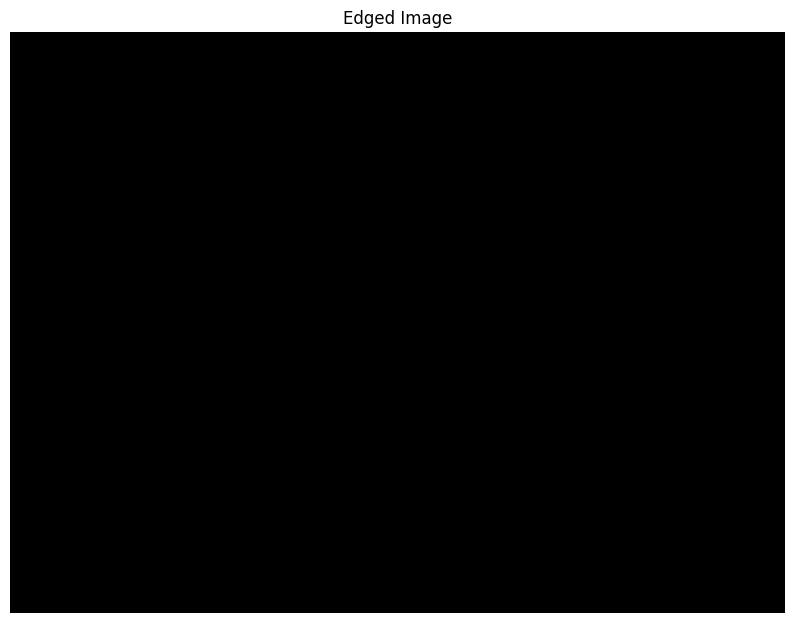

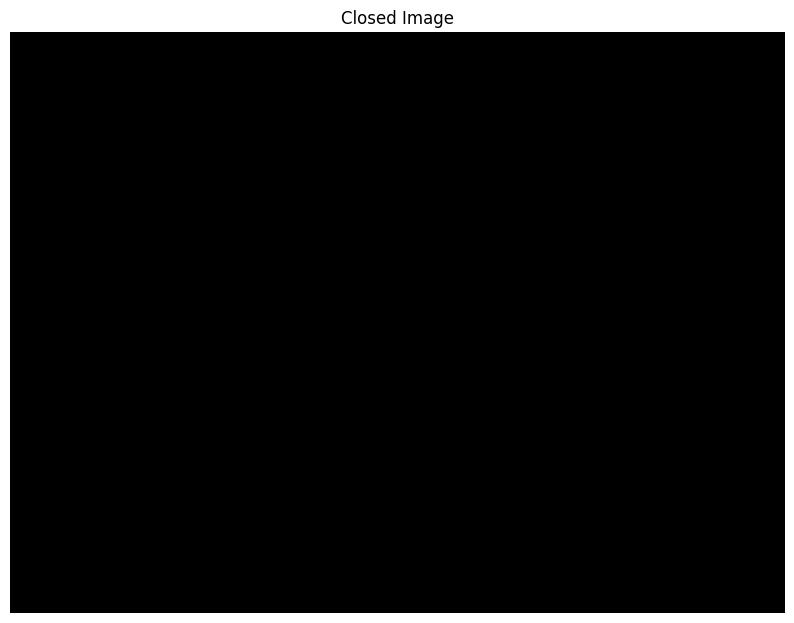

No barcode detected


In [17]:
# Example usage
crop_barcode('C://Uni//Senior 1 Sem1//CV//Project//barcode_vision//Test Case Images//06 - meen fata7 el nour 333eenaaayy.jpg', 'cropped_image.jpg')